# Assign taxonomy to feature tables

To assign taxonomy a NB classifier is required. You can download it from https://docs.qiime2.org/2023.2/data-resources/

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 200
plt.rc('legend', fontsize=8, title_fontsize=10, edgecolor='white') # using a size in points

### Read interpolated data and taxonomy files

In [2]:
wd =  './data/'

male_taxonomy = pd.read_csv(wd + 'taxonomy/male_taxonomy.tsv', sep = '\t')
female_taxonomy = pd.read_csv(wd + 'taxonomy/female_taxonomy.tsv', sep = '\t')
donorA_taxonomy = pd.read_csv(wd + 'taxonomy/2202_taxonomy.tsv', sep = '\t')
donorB_taxonomy = pd.read_csv(wd + 'taxonomy/2202_taxonomy.tsv', sep = '\t')

male_df = pd.read_csv(wd + 'ready_files/male_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T
female_df = pd.read_csv(wd + 'ready_files/female_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T.reset_index(drop=True)
donorA_df = pd.read_csv(wd + 'ready_files/donorA_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T
donorB_df = pd.read_csv(wd + 'ready_files/donorB_rarefied_18000_interpolated_pchip.tsv',  sep = '\t', index_col = [0]).T

datasets = [male_df, female_df, donorA_df, donorB_df]
subjects = ['male', 'female', 'donorA', 'donorB']

### Prepare taxonomy for plotting

In [3]:
def prepare_taxonomy(df):
        
    DF = pd.DataFrame()
    for i in range(2, 8):

        split_taxonomy = df.Taxon.str.split('; ', expand=True).iloc[:, :i]
        phylum = split_taxonomy[split_taxonomy.columns[0:]].apply(lambda x: '; '.join(x.dropna().astype(str)),axis=1).values
        DF[i] = phylum

    DF.columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Strain']
    DF['feature'] = df['Feature ID']
    
    return DF

def filter_taxonomy(input_taxonomy_df, counts_df, level, treshold):
    
    '''
    input_taxonomy_df: subjects raw taxonomy file
    counts_df: subject interpolated and rarefied counts
    level: taxonomic level at which we want to merge our results
    treshold: how many features we want to include
    '''

    taxonomy_df = prepare_taxonomy(input_taxonomy_df)
    sequence_taxonomy_dict = dict(zip(taxonomy_df.feature, taxonomy_df[level]))
    renamed_counts_df = counts_df.rename(columns = sequence_taxonomy_dict)

    mean_df = renamed_counts_df.T.reset_index().groupby(by = ['index']).sum().mean(axis=1).reset_index().sort_values(by = [0], ascending=False).reset_index(drop=True)
    
    #rename bacteria
    mean_df['name'] = np.where(mean_df['index'].isin(mean_df.iloc[:treshold]['index']), mean_df['index'], 'other')
    
    #create new dict of bacteria names
    new_level_dict = dict(zip(mean_df['index'], mean_df['name']))
    renamed_counts_df = renamed_counts_df.rename(columns = new_level_dict)
    renamed_counts_df = renamed_counts_df.T.reset_index().groupby(['index']).sum().T
    
    #change to relative abundance
    rel_ab_df = renamed_counts_df.div(renamed_counts_df.sum(axis=1), axis=0)

    return rel_ab_df

### Visualize taxonomy change in time

In [ ]:
def plot_stacked_taxonomy(df, level, subject):
    
    colors = ['#ee9b00', '#588157', '#ca6702',
      '#9b2226', '#e9c46a', '#2a9d8f',
      '#264653', '#560bad', '#e76f51',
      '#54478c', '#2c699a', '#3c096c', '#e9d8a6']
        
    
    kwargs = {'alpha':1}
    ax = df.plot(kind='bar', stacked=True, width=1,  color=colors, figsize = (20, 3), **kwargs)
    
    plt.legend(bbox_to_anchor=(1, 1), title=f'{level} \n', ncol = 1, edgecolor='white')
    
    plt.xticks(np.arange(0, (len(df)+1), 100), fontsize=8, rotation = 360)
    plt.yticks( fontsize=8)
    plt.xlabel('time point [day]', size=10)
    plt.ylabel('relative abundance', size=10)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

In [27]:
level = 'Family'
treshold = 7

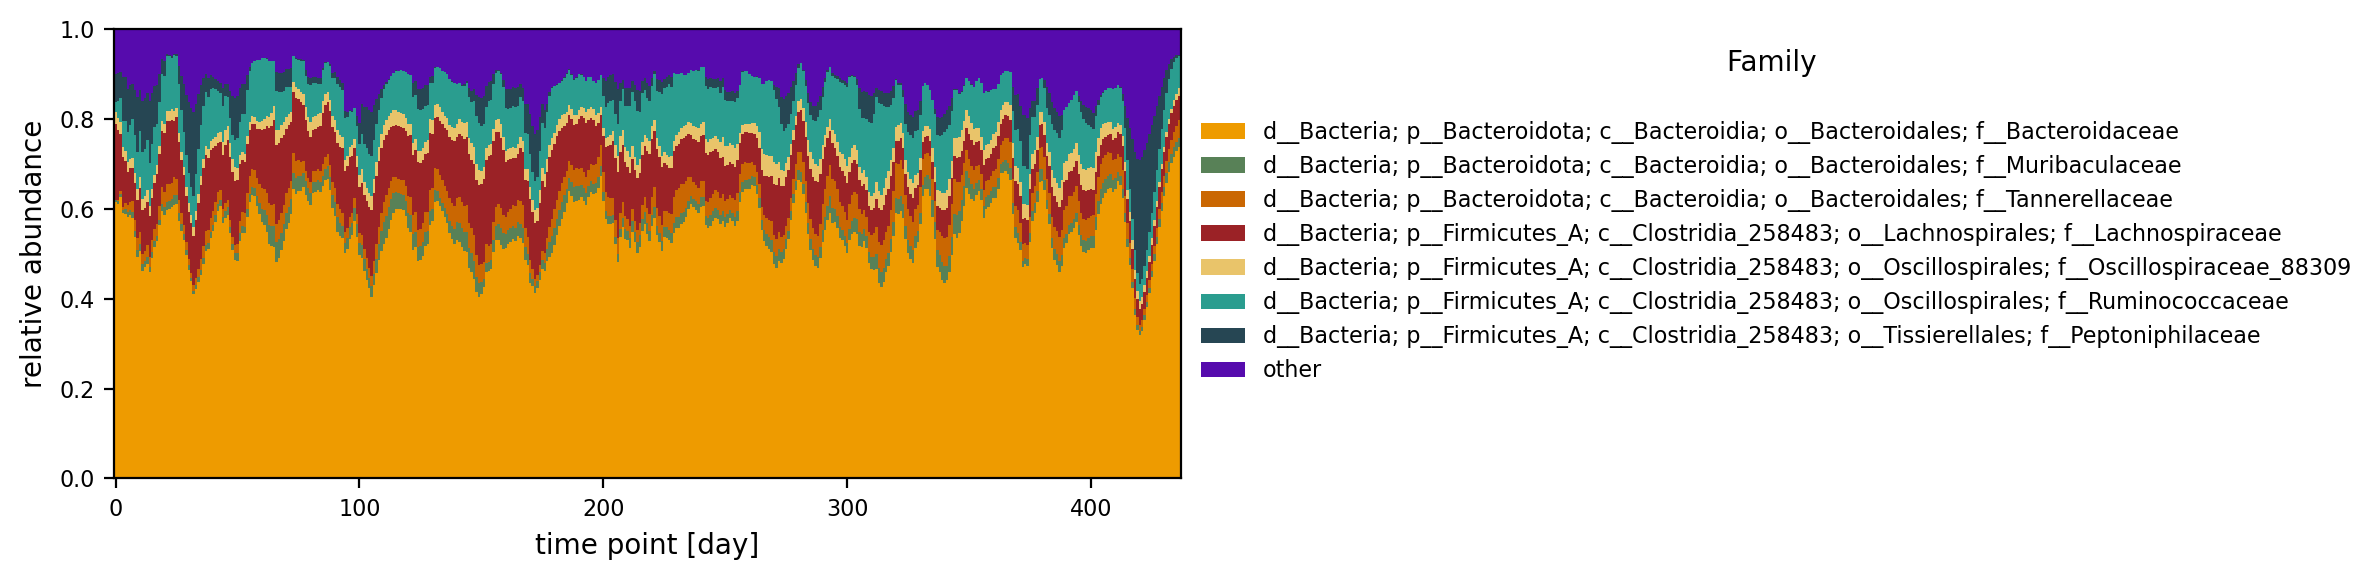

In [30]:
df = filter_taxonomy(male_taxonomy, male_df, level, treshold)
df_rolling = df.transform(lambda x: x.rolling(window=7).mean()).dropna().reset_index(drop=True)
plot_stacked_taxonomy(df_rolling, level, 'male')

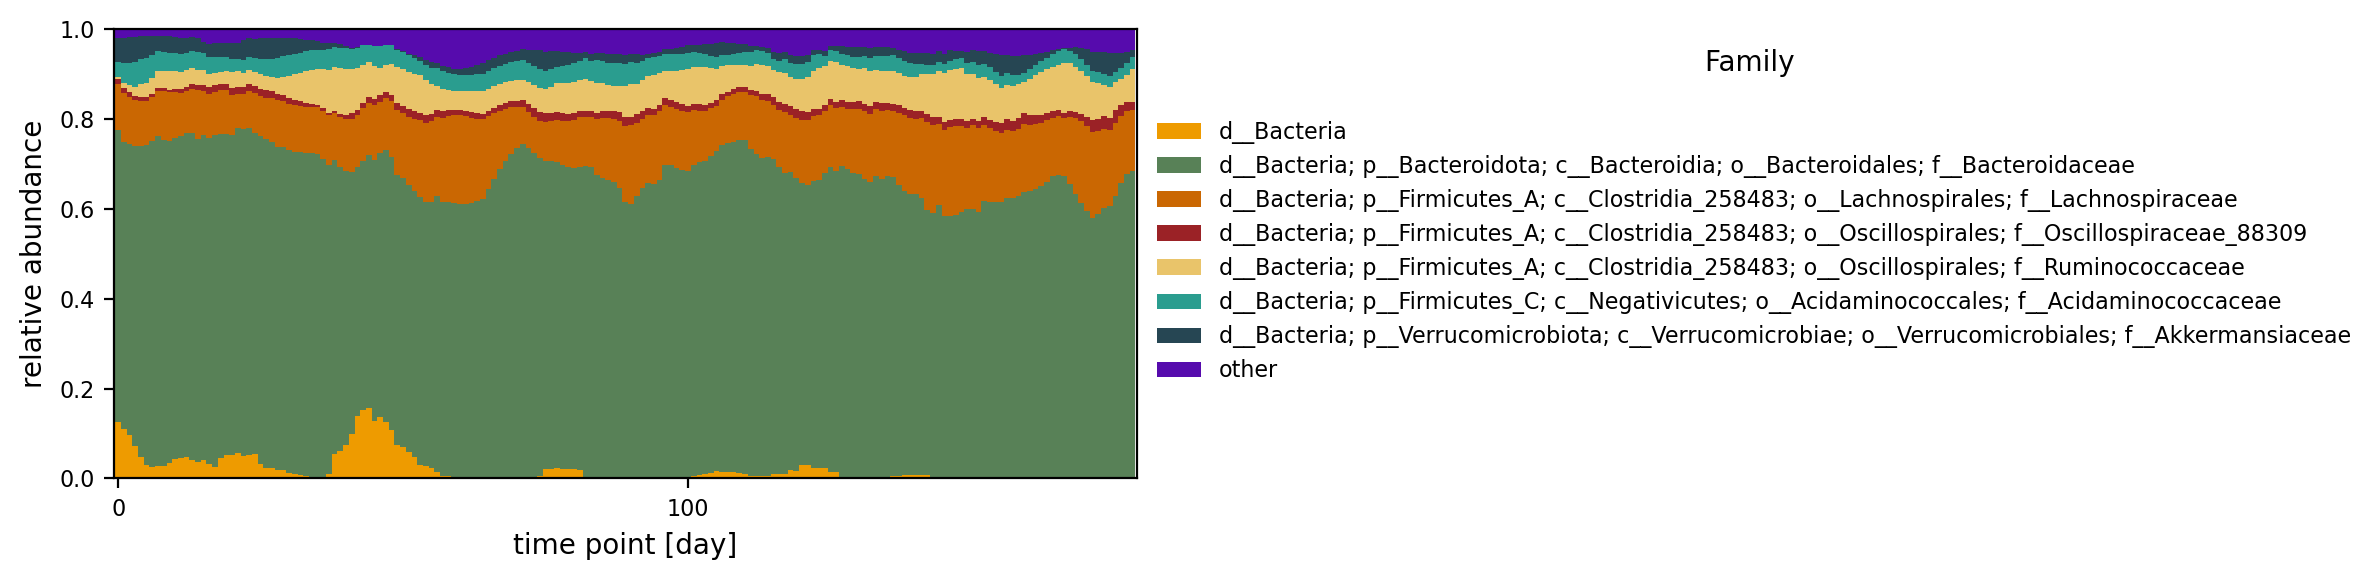

In [31]:
df = filter_taxonomy(female_taxonomy, female_df, level, treshold)
df_rolling = df.transform(lambda x: x.rolling(window=7).mean()).dropna().reset_index(drop=True)
plot_stacked_taxonomy(df_rolling, level, 'female')

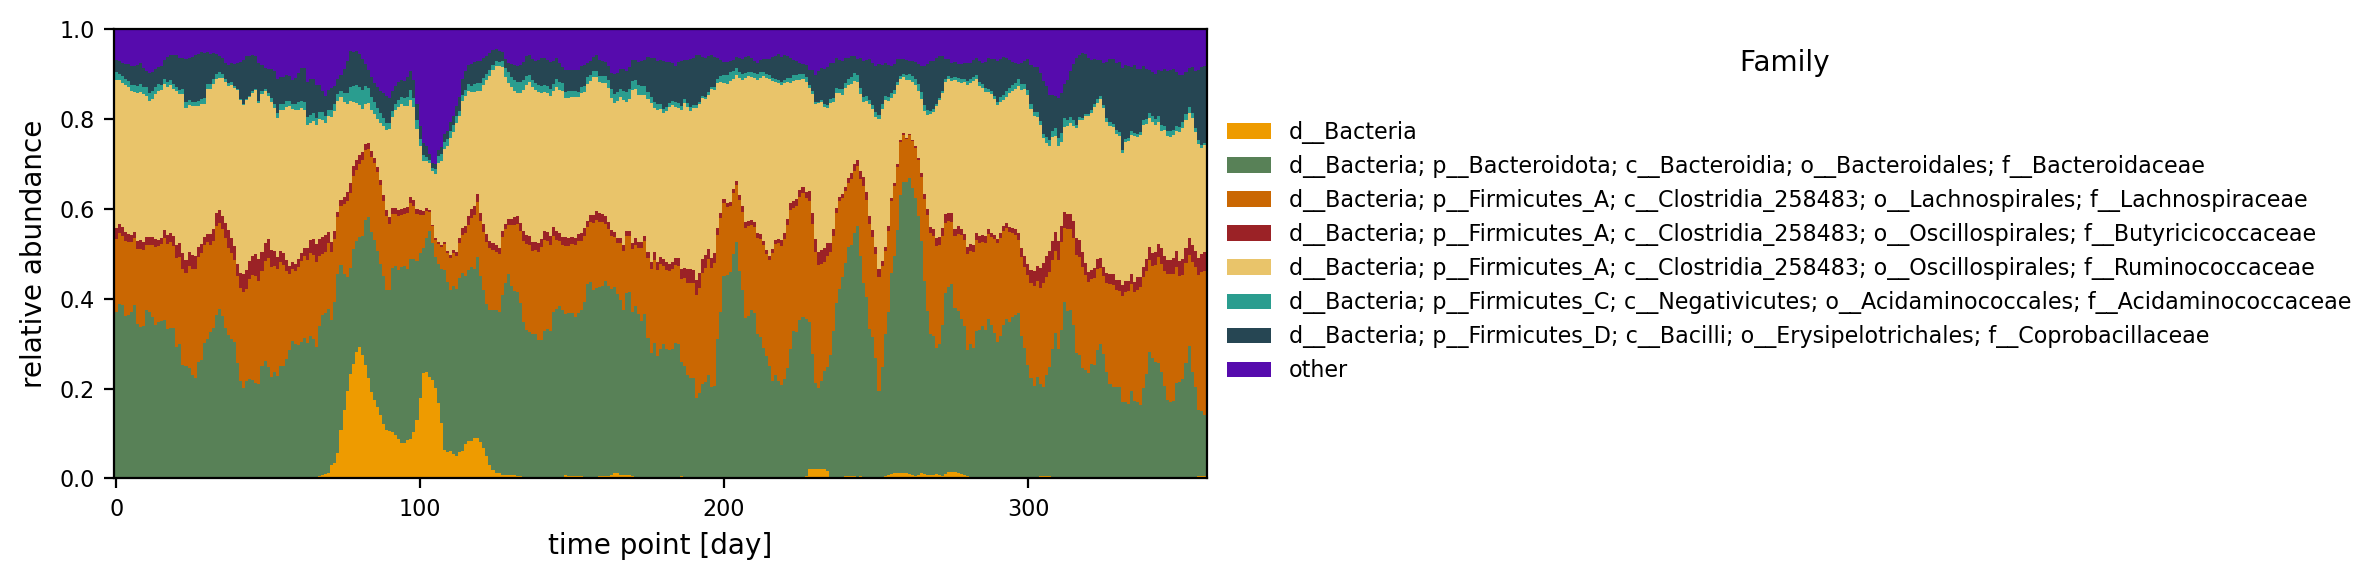

In [32]:
df = filter_taxonomy(donorA_taxonomy, donorA_df, level, treshold)
df1 = df.transform(lambda x: x.rolling(window=7).mean()).dropna().reset_index(drop=True)
plot_stacked_taxonomy(df1, level, 'donorA')

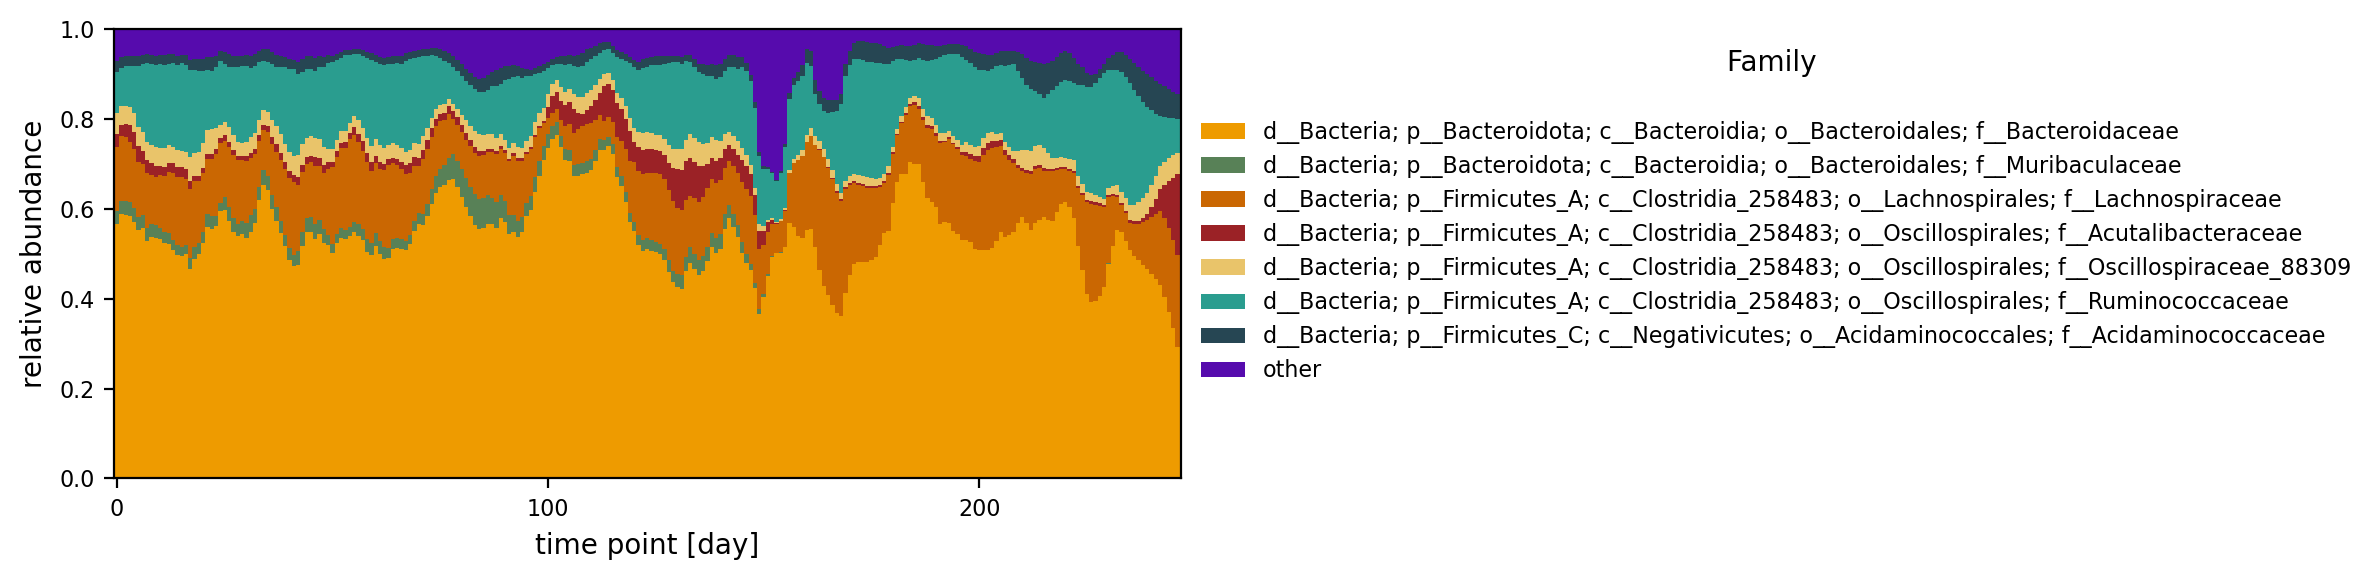

In [33]:
df = filter_taxonomy(donorB_taxonomy, donorB_df, level, treshold)
df_rolling = df.transform(lambda x: x.rolling(window=7).mean()).dropna().reset_index(drop=True)
plot_stacked_taxonomy(df_rolling, level, 'donorB')